# `Segram` basics and single document analysis

This notebook covers the basics of using `segram` package with a particular
focus on the main functionalities provided by grammar classes
(`segram.Doc`, `segram.Sent`, `segram.Phrase` and `segram.Component`)
and analysis of a single document.

<div class="alert alert-block alert-success">
For a more detailed discussion of the package and its features,
including supported languages and language models, see REAMDE in the 
root directory of the <a href="https://github.com/sztal/segram">Github repository</a> and the official documentation.
<br><br>
Furthermore, while this and other sample notebooks try to be as self-contained 
as possible, some basic familiarity with the <tt>spacy</tt> package is very much 
recommended (it has an excellent <a href="https://spacy.io/usage">documentation</a>).
</div>

<div class="alert alert-block alert-warning">
For the code to run without any problems make sure that <tt>spacy</tt>
and <tt>segram</tt> have been installed according to the instructions
from README.
</div>

## Loading and configuring language model and pipeline components

`Segram` is based on the excellent <a href="https://spacy.io/">spacy</a> 
package, which is used to solve the core NLP tasks such as tokenization, 
POS and dependency tagging and entity recognition. Thus, before `segram` can be 
used it is necessary to load and initialize a `spacy` language model.
As a matter of fact, `segram` functionalities are provided by a 
dedicated pipeline component, which is automatically registered with `spacy`
upon the package installation. **This is the correct way to parse texts
and create document objects with `segram`**.

Crucially, to do any work we first need to download and install appropriate
language models. In this respect `segram` is fully dependent on `spacy`,
so we need only to download thoroughly tested models offered by `spacy`.
We will need three different models:

1. **Main English model based on the transformer architecture.**
   In an environment in which `spacy` is already installed the
   model can be obtained with the command `python -m spacy download en_core_web_trf`.
2. **Word vector model.** The transformer model is powerful, but it does
   not provide static word vectors, but only context-dependent vectors.
   To use structured matching implemented in `segram` we need to have access
   to context-free word vectors, so we obtain them from a different model.
   This one can be downloaded with: `python -m spacy download en_core_web_lg`.
3. **Coreference resolution model.** The last model will be used for implementing
   coreference resolution. This is still experimental feature not integrated
   into the core of `spacy`, so that is why we need to use an extra model
   for that. It can be installed with:
   `pip install https://github.com/explosion/spacy-experimental/releases/download/v0.6.1/en_coreference_web_trf-3.4.0a2-py3-none-any.whl`.

In [1]:
import spacy
nlp = spacy.load("en_core_web_trf")
nlp.add_pipe("segram", config={
    "vectors": "en_core_web_lg"
})
nlp.add_pipe("segram_coref")

Let us now understand the meaning of the code we executed.

1. Import `spacy` package.
2. Load model for English using `spacy.load` function.
3. Use `.add_pipe` method to add dedicated `segram` component.
   The `vectors` option from the config specifies the name of a model
   used for obtaining context-free word vectors. This is useful in the
   case we want to use a model without such vectors such as `en_core_web_trf`
   for solving core NLP tasks. 
4. Finally, we use `.add_pipe` again to add `segram_coref` module for 
   coreference resolution.

## Parsing texts into document & `segram` data model

In this section we will learn how to parse raw texts (`str` objects)
to get document objects providing us with all the nice methods for doing
semantic grammar analysis. Along the way we will see a quick overview
of the data model of `segram`.

The code chunk below provides a simple text from an article covering the war in Syria
(see `README` in the `examples/data` directory to learn mode about the dataset).

<div class="alert alert-block alert-success">
We cover more complex analyses based on multiple texts
in <tt>2-stories-and-frames.ipynb</tt> notebook.
</div>

In [2]:
text = (
    "Victims of a suspected chemical attack in Syria appeared to show symptoms"
    " consistent with reaction to a nerve agent the World Health Organization said on Wednesday."
    " \"Some cases appear to show additional signs consistent with exposure to "
    "organophosphorus chemicals a category of chemicals that includes nerve agents\""
    " WHO said in a statement putting the death toll at at least 70."
    " The United States has said the deaths were caused by sarin nerve gas dropped by Syrian aircraft."
    " Russia has said it believes poison gas had leaked from a rebel chemical weapons depot struck by Syrian bombs."
    " Sarin is an organophosporus compound and a nerve agent."
    " Chlorine and mustard gas which are also believed to have been used in the past in Syria are not."
    " A Russian Defence Ministry spokesman did not say what agent was used "
    "in the attack but said the rebels had used the same chemical weapons in Aleppo last year."
    " The WHO said it was likely that some kind of chemical was used in the attack "
    "because sufferers had no apparent external injuries and died from a rapid onset"
    " of similar symptoms including acute respiratory distress. "
    "It said its experts in Turkey were giving guidance to overwhelmed "
    "health workers in Idlib on the diagnosis and treatment of patients and "
    "medicines such as Atropine an antidote for some types of chemical exposure "
    "and steroids for symptomatic treatment had been sent. "
    "A U.N. Commission of Inquiry into human rights in Syria has previously said"
    " forces loyal to Syrian President Bashar al-Assad have used lethal chlorine gas on multiple occasions."
    " Hundreds of civilians died in a sarin gas attack in Ghouta on the outskirts of Damascus in August 2013."
    " Assads government has always denied responsibility for that attack."
    " Syria agreed to destroy its chemical weapons in 2013 under a deal brokered by Moscow and Washington."
    " But Russia a Syrian ally and China have repeatedly vetoed any United Nations "
    "move to sanction Assad or refer the situation in Syria to the International Criminal Court."
    " \"These types of weapons are banned by international law because they represent an intolerable barbarism\""
    " Peter Salama Executive Director of the WHO Health Emergencies Programme said in the WHO statement."
)

Now, we are ready to create our first document object. We simply follow the API
of `spacy` and pass the text to our language model stored as `nlp` variable.

In [3]:
spacy_doc = nlp(text)
spacy_doc   # type(doc) --> spacy.tokens.doc.Doc

Victims of a suspected chemical attack in Syria appeared to show symptoms consistent with reaction to a nerve agent the World Health Organization said on Wednesday. "Some cases appear to show additional signs consistent with exposure to organophosphorus chemicals a category of chemicals that includes nerve agents" WHO said in a statement putting the death toll at at least 70. The United States has said the deaths were caused by sarin nerve gas dropped by Syrian aircraft. Russia has said it believes poison gas had leaked from a rebel chemical weapons depot struck by Syrian bombs. Sarin is an organophosporus compound and a nerve agent. Chlorine and mustard gas which are also believed to have been used in the past in Syria are not. A Russian Defence Ministry spokesman did not say what agent was used in the attack but said the rebels had used the same chemical weapons in Aleppo last year. The WHO said it was likely that some kind of chemical was used in the attack because sufferers had no 

This gave us a standard `spacy` document. To enjoy `segram` features we need
to convert it to so-called **grammar document**, which is a wrapper object that
sits on top of a document (using composition instead of inheritance)
and exposes the semantic grammar framework to the user.

Since this is a document composed of multiple sentences, let us first focus
on the first sentence. During parsing documents are segmented into sentences
(and sentences into tokens, typically but not necessarily corresponding to individual words),
so we can easily iterate over the sentence sequence of a document.

In [4]:
doc = spacy_doc._.segram  # convert the spacy document to a grammar doc
sent = doc.sents[0]       # take the first sentence
sent

Victims of a suspected chemical attack in Syria appeared to show symptoms consistent with reaction to a nerve agent the World Health Organization said on Wednesday. 

We can readily tell that we are dealing now with a sentence coming from a 
grammar document produced by `segram` as it is printed differently and uses 
colors to denote different **components**.

### Components

Components are groups of tokens (not necessarily contiguous) controlled
by a syntactically (and semantically) important head token. There are four
types of components, which roughly correspond to the main parts-of-speech
(i.e. are based on a coarse-grained POS typology):

* Verbs (red) with alias `Verb`
* Nouns (yellow/orange) with alias `Noun`
* Descriptions (pink/violet) with alias `Desc`
* Prepositions (green/lime) with alias `Prep`
  
Importantly, components within a sentence are non-overlapping, and jointly they
form its partition. This is visually represented using different colors
when printing grammar sentences to the console.

In [5]:
sent

Victims of a suspected chemical attack in Syria appeared to show symptoms consistent with reaction to a nerve agent the World Health Organization said on Wednesday. 

Why do we care about the aliases? To understand this let us see what is the
actual class of, let us say, a verb component in our sentence.

In [6]:
verb = sent.verbs[0]  
# use `.nouns`, `.descs` and `.preps` to access other types
# all components are given by `.components` property
type(verb), verb.alias

(segram.nlp.backend.rulebased.lang.en.grammar.components.RulebasedEnglishVerb,
 'Verb')

Clearly, it is not a pure verb but a `RulebasedEnglishVerb`. This is an
implementation detail, so we do not care. However, let us note that its
alias is simply a string `"Verb"`.

In principle, we could look for
verbs using standard `isnstance` check, but this requires locating and importing
base component classes appropriate for testing, so it would be nice to have
an alternative way of testing whether a component belongs to a given type
just by providing a string, which is easier to do on-the-fly. This is one
of several reasons it is nice to have aliases.

In [7]:
# Finding verbs using `isinstance`
from segram.grammar import Verb
sent.components.filter(isinstance, Verb)

(appeared, to show, said)

In [8]:
# Using alias (importing `Verb` is not necessary)
sent.components.filter("match", alias="Verb")

(appeared, to show, said)

Note that we used a custom framework for dealing with the rich data produced
by `segram`. Here we filtered the list of components by matching their alias
strings (stored under the `.alias` attribute) against the pattern `"Verb"`.
The `.match` method we used is shared by all grammar element classes, so we
can access its docstring directly from the sentence object we are working with.

In [9]:
sent.match?

Signature:
sent.match(
    _pattern: str | None = None,
    _flag: re.RegexFlag = re.NOFLAG,
    _ignore_missing: bool = False,
    **kwds: Union[Any, Callable[[Any], bool]],
) -> re.Pattern | None
Docstring:
Match element text against a regex pattern
using :func:`re.search` function.

Parameters
----------
_pattern
    Regular expression pattern used for matching.
    No matching is done when ``None``.
_flag
    Regex flag.
_ignore_missing_fields
    Should missing fields on ``self`` be ignored.
**kwds
    Other keyword arguments can be used for testing
    values of different attributes on ``self``.
    If callables are passed as values then they are
    expected to be predicate functions returning
    boolean values.
File:      ~/Coding/python/segram/segram/grammar/abc.py
Type:      method

This easy filtering was possible because the `components` property 
(and this applies to all data properties and attributes of grammar classes)
returns something that looks and behaves like a tuple, but it not exactly a
vanilla tuple  but rather its subclass called `DataTuple`.

<div class="alert aler-block alert-success">
Currently, <tt>segram</tt> implements <tt>Data*</tt> versions of <tt>tuple</tt>,
<tt>list</tt>, <tt>dict</tt> as well as <tt>DataIterator</tt> that can be
used to iterate over data provided in a memory-independent manner.
</div>

In [10]:
type(sent.components), sent.components

(segram.datastruct.collections.DataTuple,
 (Victims,
  of,
  suspected,
  chemical,
  a attack,
  in,
  Syria,
  appeared,
  to show,
  symptoms,
  consistent,
  with,
  reaction,
  to,
  nerve,
  a agent,
  the World Health Organization,
  said,
  on,
  Wednesday))

`DataTuple` is just a plain old tuple with several additional methods for data
filtering and processing, most importantly, `map`, `filter`, `sort`, `pipe`,
`groupby`, `get` and `flat`. We will discuss them in more detail shortly, 
but first let us try to do something slightly more useful and count occurrences
of distinct descriptions in the whole document based on their lemmas. 
To do so we will need a little help of the `Counter` class from the `collections` module of the Python standard library.

Below we describe this relatively simple processing pipeline step-by-step
in the comments in the code.

1. Get sentence sequence using `doc.sents`
2. For each sentence get the list of descriptions using `get("descs")`.
3. Flatten the resulting list of lists using `.flat`.
4. Group resulting items by unique lemmas of their head tokens after
   coreference resolution using `c.head.coref.lemma` executed for each item.
5. Sort resulting dictionary of groups by group sizes.

In [11]:
grouped = doc.sents \
    .get("descs") \
    .flat \
    .groupby(lambda c: c.head.coref.lemma) \
    .sort("values", len, reverse=True)
grouped

{'syrian': (Syrian,
  Syrian,
  Syrian,
  Syrian),
 'chemical': (chemical,
  chemical,
  chemical),
 'consistent': (consistent, consistent),
 'Syria': (its[Syria],),
 'acute': (acute,),
 'additional': (additional,),
 'also': (also,),
 'always': (always,),
 'apparent': (apparent,),
 'external': (external,),
 'international': (international,),
 'intolerable': (intolerable,),
 'lethal': (lethal,),
 'likely': (likely,),
 'loyal': (loyal,),
 'multiple': (multiple,),
 'overwhelmed': (overwhelmed,),
 'previously': (previously,),
 'rapid': (rapid,),
 'rebel': (rebel,),
 'repeatedly': (repeatedly,),
 'respiratory': (respiratory,),
 'same': (same,),
 'similar': (similar,),
 'such': (such,),
 'suspect': (suspected,),
 'symptomatic': (symptomatic,),
 'the World Health Organization': (its[the World Health Organization],)}

Let us pause for a while now and take a look at what was gathered under
a key `"the World Health Organization"`, which neither an adjective nor an
adverb, so perhaps it should not be present in our grouping dictionary?

In [12]:
grouped["the World Health Organization"]

(its[the World Health Organization],)

But note that the actual token is "its", and the WHO appears only after the
coreference resolution (this is indicated by the value in the square brackets).
Thanks to this we know what "its" is really referring to, and the data we gathered
is consistent with what we asked for by specifying `.coref.lemma`.

### Phrases and phrase graphs

Sentence are composed of components, but they can be also viewed from 
a more complex vantage point of phrases, which are higher-order grammatical
(and more semantic) structures that form a nested hierarchy that takes the 
form of a directed acyclic graph (DAG) of a sentence.

More concretely, a phrase consists of a head component and zero or more
controlled phases (children) that are related to the parent by well-defined 
syntactic relationships such as being a subject of a verb. The phrasal graph 
of a sentence can be easily inspected using the `.graph` property
(to make the graph structure more legible only phrase heads are printed).
Annotations next to the nodes specify syntactic relationships between
children and parents.

See `segram.symbols.Dep?` for the list of all dependency symbols
and their descriptions.

In [13]:
sent.graph

said
    appeared [subcl]
        Victims [subj]
            of [prep]
                a attack [pobj]
                    suspected [desc]
                    chemical [desc|nmod]
                    in [prep]
                        Syria [pobj]
        to show [xcomp]
            symptoms [dobj]
                consistent [desc]
                    with [prep]
                        reaction [pobj]
                            to [prep]
                                a agent [pobj]
                                    nerve [nmod]
    the World Health Organization [subj]
    on [prep]
        Wednesday [pobj]

Under the hood, the graph is just a mapping.

In [14]:
dict(sent.graph)

{Victims of a suspected chemical attack in Syria: (of a suspected chemical attack in Syria,),
 of a suspected chemical attack in Syria: (a suspected chemical attack in Syria,),
 suspected: (),
 chemical: (),
 a suspected chemical attack in Syria: (suspected,
  chemical,
  in Syria),
 in Syria: (Syria,),
 Syria: (),
 Victims of a suspected chemical attack in Syria appeared to show symptoms consistent with reaction to a nerve agent: (Victims of a suspected chemical attack in Syria,
  to show symptoms consistent with reaction to a nerve agent),
 to show symptoms consistent with reaction to a nerve agent: (symptoms consistent with reaction to a nerve agent,),
 symptoms consistent with reaction to a nerve agent: (consistent with reaction to a nerve agent,),
 consistent with reaction to a nerve agent: (with reaction to a nerve agent,),
 with reaction to a nerve agent: (reaction to a nerve agent,),
 reaction to a nerve agent: (to a nerve agent,),
 to a nerve agent: (a nerve agent,),
 nerve: (

<div class="alert alert-block alert-success">
Note that the fact that phrase graphs store phrase objects as keys means
that phrases are <strong>hashable</strong>. This is true for all grammar
element classes (components, phrases, sentences and documents).
Components, phrases and sentences are also sortable as long as they belong
to the same document.
</div>

By viewing the phrase graph as a simple `dict` we now see how phrases are
represented when printed to the console.

* The colored part correspond to the phrase head and its non-clause children.
* Grayed-out part are dependent clauses, or child phrases with their own verbs.
* Colors are used to mark different types of children such as subjects.

<div class="alert alert-block alert-success">
Color theme can be configured by modifying global settings
stored in <tt>segram.settings</tt>.
</div>

Crucially, thanks to the fact that phrasal graphs are DAGs by construction,
it is always guaranteed that a starting from a given phrase and traversing
the graph downwards (through the **subdag**) or upward (through the **supdag**)
will end at some point as there are no cycles.

* Phrases in a sentence can be accessed with `sent.phrases`.
* Parents of a phrase can be accessed using `phrase.parents`.
* Children can be accessed using `phrase.children`.
* Subdag can be accessed using `phrase.subdag`.
* Supdag can be accessed using `phrase.supdag`.

To illustrate the power of thinking in terms of phrases below we design
a relatively simple query finding all sentences with a top root phrase,
which describe a statement made by the World Health Organization. Thus,
we are looking for phrases with subject being WHO and verb being "say".
So what we do below is:

1. Iterate over sentences in our document.
2. Extract root phrases (`sent.proots`) of sentences and flatten the resulting 
   list of lists.
3. Select only those which are verb phrases (`alias=="VP"`), have a subject
   with text matching the regex pattern finding WHO, and a verb of which
   head token lemma is "say".
4. Finally, we take back the unique whole sentences with the matching phrases.

In [15]:
who_sents = doc.sents \
    .get("proots").flat \
    .filter("match", **{
        "alias": "VP",
        "subj": lambda x: \
            x.filter("match", "World Health Organization|WHO").any(),
        "verb": lambda x:
            x.get("head").filter("match", lemma="say").any()
    }) \
    .get("sent") \
    .unique() \

for sent in who_sents:
    print(sent)

Victims of a suspected chemical attack in Syria appeared to show symptoms consistent with reaction to a nerve agent the World Health Organization said on Wednesday. 
"Some cases appear to show additional signs consistent with exposure to organophosphorus chemicals a category of chemicals that includes nerve agents" WHO said in a statement putting the death toll at at least 70. 
The WHO said it was likely that some kind of chemical was used in the attack because sufferers had no apparent external injuries and died from a rapid onset of similar symptoms including acute respiratory distress. 
It[the World Health Organization] said its[the World Health Organization] experts in Turkey were giving guidance to overwhelmed health workers in Idlib on the diagnosis and treatment of patients and medicines such as Atropine an antidote for some types of chemical exposure and steroids for symptomatic treatment had been sent. 
"These types of weapons are banned by international law because they[types

We may use our result now to print the whole document nicely so only the matching
phrases are highlighted with colors.

In [16]:
for sent in doc.sents:
    print(sent.to_str(color=sent in who_sents))

Victims of a suspected chemical attack in Syria appeared to show symptoms consistent with reaction to a nerve agent the World Health Organization said on Wednesday. 
"Some cases appear to show additional signs consistent with exposure to organophosphorus chemicals a category of chemicals that includes nerve agents" WHO said in a statement putting the death toll at at least 70. 
The United States has said the deaths were caused by sarin nerve gas dropped by Syrian aircraft. 
Russia has said it[Russia] believes poison gas had leaked from a rebel chemical weapons depot struck by Syrian bombs. 
Sarin is an organophosporus compound and a nerve agent. 
Chlorine and mustard gas which are also believed to have been used in the past in Syria are not. 
A Russian Defence Ministry spokesman did not say what agent was used in the attack but said the rebels had used the same chemical weapons in Aleppo last year. 
The WHO said it was likely that some kind of chemical was used in the attack because su

### Conjuncts

Why did we talk about root phrases instead of a single root phrase corresponding
to the main clause of the entire sentence? We did, because one of the things
that `segram` does in order to make semantic analysis based on grammatical
structure more feasible is redesigning the syntactic tree in order to reveal
the true syntactic-semantic roles of conjuncts, which are typically represented
as children of the leading token in a group formed by a coordinating conjunction.
And this is why in `segram` we have a phrase graph (DAG) instead of a tree.
After promoting conjuncts higher in the hierarchy we have to relax the structural
constraints imposed on our representation of syntactic structure.

To better see this let us consider the following sentence.

In [17]:
sent = nlp(
    "Recent breakthroughs in artificial inteligence "
    "may reshape the society and significantly impact the economic system."
)._.segram.sents[0]
sent

Recent breakthroughs in artificial inteligence may reshape the society and significantly impact the economic system.

By inspecting the phrase DAG we can easily see that this sentence has two
root phrases (phrases with no parents).

In [18]:
sent.graph

may reshape
    breakthroughs [subj]
        Recent [desc]
        in [prep]
            inteligence [pobj]
                artificial [desc]
    the society [dobj]
impact
    breakthroughs [subj]
        Recent [desc]
        in [prep]
            inteligence [pobj]
                artificial [desc]
    significantly [desc]
    the system [dobj]
        economic [desc]

It is so, because the phrases headed by "reshape" and "impact" are linked
by a coordinating conjunction token "and", which means that effectively
they play the same role in the sentence, so the subject of "reshape"
is also the subject of "impact". And this is correctly recognized by `segram`.

Conjoined groups like this one are represented with a special sequence type
`segram.grammar.conjuncts.Conjunct`, which also keeps track of the information
of the conjunction tokens (both coordinating conjunction, and a potential preconjunction).

In [19]:
sent.proots

[and](Recent breakthroughs in artificial inteligence may reshape the society, Recent breakthroughs in artificial inteligence significantly impact the economic system)

For performance reasons non-root phrases getters such as `sent.phrases`,
do not group them in conjunct groups. However, this can be done very easily
when needed.

In [20]:
sent.phrases.conjs
# Note the sixth item which is a conjunct group of the two root phrases

((Recent),
 (Recent breakthroughs in artificial inteligence),
 (in artificial inteligence),
 (artificial),
 (artificial inteligence),
 [and](Recent breakthroughs in artificial inteligence may reshape the society, Recent breakthroughs in artificial inteligence significantly impact the economic system),
 (the society),
 (significantly),
 (economic),
 (the economic system))

### Sentence as a hypergraph of phrases

The fact that sentences are formed of phrases, which themselves group
components and other phrases (or more generally tokens), means that there
is a correspondence between such conceived syntactic structure of a sentence
and a hypergraph with hyperedges corresponding to phrases.

Currently, `segram` does not provide any features explicitly based on this
idea, but they will be added in future releases. Moreover, it is already
relatively easy to convert `segram` data to hypergraphs compatible with
libraries for analysis of higher-order networks such as [XGI](https://pypi.org/project/xgi/).
Some examples are presented in notebook `3-representations.ipynb`.

And below is an example of a hypergraph representation of the sentence:

In [21]:
nlp(
    "Recent breakthroughs in artificial inteligence "
    "may reshape the society in some good and some bad ways."
)._.segram

Recent breakthroughs in artificial inteligence may reshape the society in some good and some bad ways.

![DD](../docs/figures/hypergraph.png)

## Word vector matching

Last but not least, `segram` offers tool for more fuzzy filtering and selection
of documents, sentences and phrases based on context-free word vectors,
which can be particularly useful in combination with the strict grammatical
filterig.

In [22]:
doc.phrases \
    .filter("match", "in Syria", alias="PP") \
    .get("sent") \
    .unique() \
    .tuple \
    .sort("similarity", {
        "descs": "chemical",
        "nouns": "attack"
    }, show_keys=True, reverse=True)

((0.7550989985466003,
  Victims of a suspected chemical attack in Syria appeared to show symptoms consistent with reaction to a nerve agent the World Health Organization said on Wednesday. ),
 (0.524234265089035,
  A U.N. Commission of Inquiry into human rights in Syria has previously said forces loyal to Syrian President Bashar al-Assad have used lethal chlorine gas on multiple occasions. ),
 (0.43509475886821747,
  Chlorine and mustard gas which are also believed to have been used in the past in Syria are not. ),
 (0.33908049762248993,
  But Russia a Syrian ally and China have repeatedly vetoed any United Nations move to sanction Assad or refer the situation in Syria to the International Criminal Court. ))

## Semantic similarity

`segram` provides also some experimental measures of semantic similarity
based on comparisons between word vectors structured by the syntactic
structure. The idea is that by comparing only vectors corresponding to tokens
with similar syntactic roles a better numerical description of the semantics
of a given phrase or sentence can be obtained. Currently, three approaches
for comparing phrases and sentences are supported:

* `average` is the traditional comparison based on average vectors calculated
  over all tokens.
* `components` compares average vectors calculated in buckets of different
  components types (list of names is defined in `.component_names` attributes
  of phrase and sentence objects).
* `phrases` compares average vectors calculated for different phrase head
  components and controlled phrases (phrase DAG children). List of types
  of controlled phrases is stored in the attribute `.controlled_names`.

In the case of `components` and `phrases` method `weights` parameter can
be used to define custom weighting scheme for averaging cosine similarities
for different types.

In [23]:
s1 = nlp(
    "Recent breakthrough in artificial intelligence may reshape "
    "the society and the world economic system."
)._.segram.sents[0]
s2 = nlp(
    "Recent breakthroughd in artificial intelligence may "
    "bring a lot of changes, some of them good and some bad."
)._.segram.sents[0]
s3 = nlp(
    "The Roman army has arrived at the river bank, ready to face the Gauls."
)._.segram.sents[0]

sents = [s1, s2, s3]

for i, si in enumerate(sents):
    for sj in sents[:i]:
        print(si)
        print(sj)
        print({ 
            m: si.similarity(sj, method=m) 
            for m in ("average", "components", "phrases")
        })

Recent breakthroughd in artificial intelligence may bring a lot of changes, some of them[lot] good and some bad.
Recent breakthrough in artificial intelligence may reshape the society and the world economic system.
{'average': 0.8861303925514221, 'components': 0.5730947852134705, 'phrases': 0.8046939373016357}
The Roman army has arrived at the river bank, ready to face the Gauls.
Recent breakthrough in artificial intelligence may reshape the society and the world economic system.
{'average': 0.804441511631012, 'components': 0.28998085856437683, 'phrases': 0.1524584690729777}
The Roman army has arrived at the river bank, ready to face the Gauls.
Recent breakthroughd in artificial intelligence may bring a lot of changes, some of them[lot] good and some bad.
{'average': 0.7238965630531311, 'components': 0.2942243814468384, 'phrases': 0.15636897087097168}


The results above indicate that the structured methods are perhaps better
at discriminating between semantically non-similar sentences.
Importantly, the structured methods are still proper similarity methods
for which it holds that `sim(x, x) == 1` and `sim(x, y) == sim(y, x)`.
This means that they are proper kernels leading to positive definite
matrices of pairwise similarities.

In the case of self-similarity, `sim(x, x) == 1`, the actual results may
be a bit lower than `1` due to accumulated floating point inaccuracies.

In [24]:
for si in sents:
    for sj in sents:
        for method in ("average", "components", "phrases"):
            if si is sj:
                assert si.similarity(sj, method=method) >= .99
            else:
                assert si.similarity(sj, method=method) == sj.similarity(si, method=method)

### Example: finding main themes in a document

Last but not least, one can use semantic similarity methods provided
by `segram`, for instance, to try to identify main themes of a document.
Here we do this for the document we studied. The strategy is simple,
we compute a kernel matrix of pairwise similarities between sentences and then 
use it to find a 2D embedding for sentences through eigendecomposition.
Finally, we apply agglomerative clustering with Ward linkage based on the
distances in the 2D embedding space.

<div class="alert alert-block alert-warning">
Semantic similarity methods are currently very experimental and we do not
make any claims here regarding their superiority over any other methods.
What we present here is just an example of how they can be used, which is
at least somewhat supportive of the idea that these methods may make some
sense in practive.
<div>

In [25]:
from textwrap import wrap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering

sents = doc.sents
S = np.zeros((len(sents), len(sents)), dtype=float)

for i, si in enumerate(sents):
    for j, sj in enumerate(sents[:i]):
        S[i, j] = si.similarity(sj, method="phrases")

S += S.T
np.fill_diagonal(S, 1)
S = (S + S.T) / 2

L, V = np.linalg.eigh(S)
L = np.diag(L)
V = V
Z = (V@np.sqrt(L))[:, -2:]
var_explained = L.diagonal() / L.diagonal().sum()

hclust = AgglomerativeClustering(
    n_clusters=2, 
    metric="euclidean", 
    linkage="ward"
).fit(Z)

groups = {}
for label in np.unique(hclust.labels_):
    mask = hclust.labels_ == label
    groups[label] = (
        np.arange(len(sents))[mask],
        [ s for s, m in zip(sents, mask) if m ],
        Z[mask]
    )

Of course, as the code above shows, we were quite naive here and just 
arbitrarily enforced a solution with two clusters. In practice some sort
of selection of the optimal number of clusters should be used. But, for the
sake of simplicity, here we will not care about such details.

It seems that what we found are two clusters that can be roughly summarized as:

1. Sentences related to the supposed use of chemical weapons by Syria.
2. Sentences related to more generic descriptions of types of chemical weapons
   and symptoms they produce.

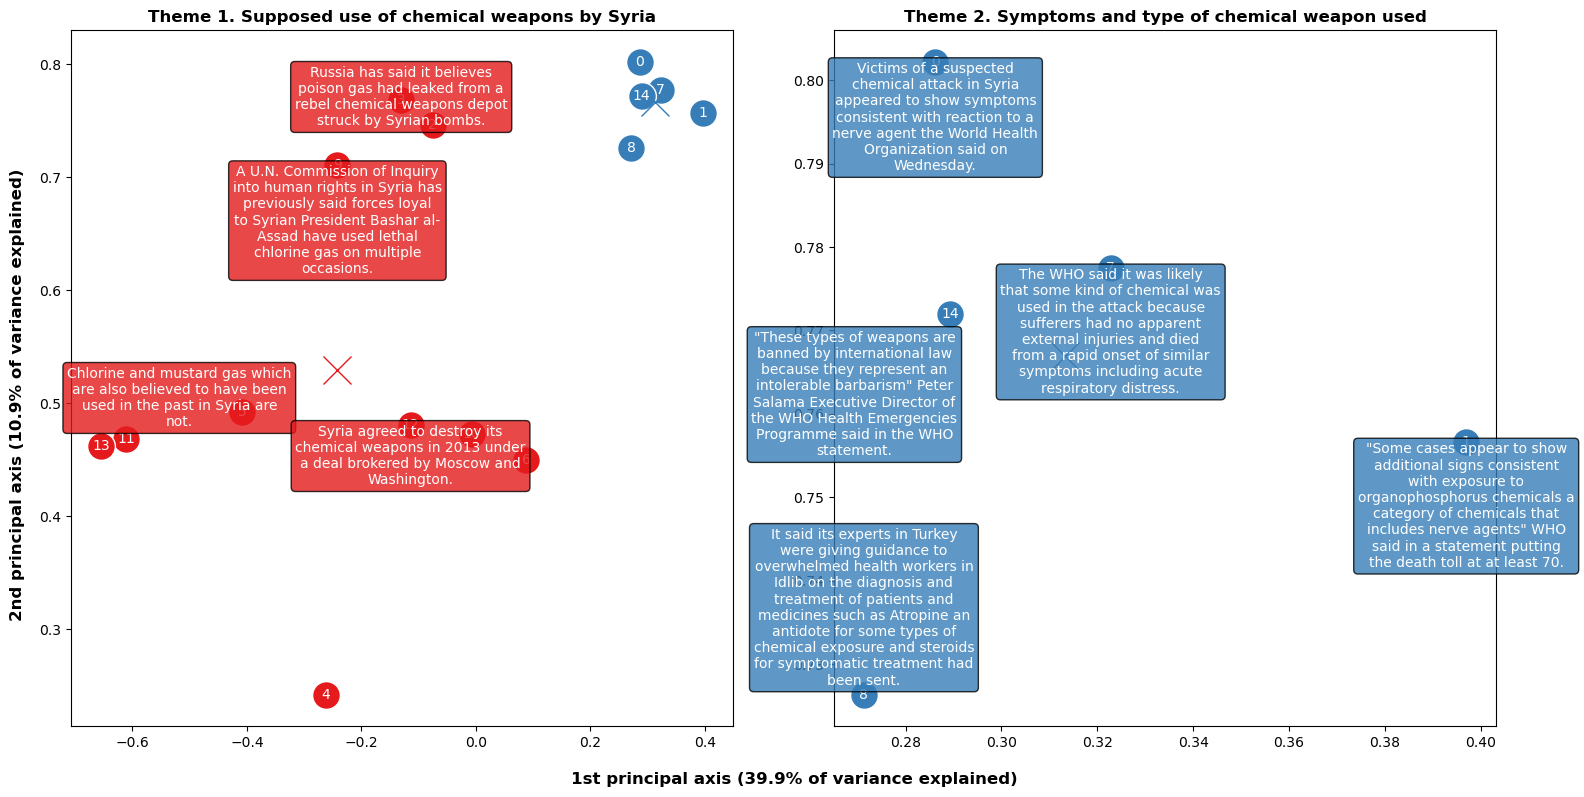

In [26]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))
cmap = plt.cm.Set1

def plot_group(groups, label, ax, show=()):
    idx, _sents, X = groups[label]
    color = cmap(label)
    pkws = dict(marker="o", color=color, markersize=20, markeredgecolor="white")
    tkws = dict(fontsize=10, ha="center", va="center", color="white")
    bbox = dict(boxstyle="round", facecolor=color, alpha=.8)
    ax.plot(*X.T, ls="None", **pkws)
    for i, xy in zip(idx, X):
        ax.text(*xy, i, **tkws)
    centroid = X.mean(axis=0)
    ax.plot(*centroid, marker="x", color=color, markersize=20)
    # show = [5, 12, 9]
    if show:
        for i, sent, xy in zip(idx, _sents, X):
            x, y = xy
            if i not in show:
                continue
            if (_xy := show[i]):
                x += _xy[0]
                y += _xy[1]
            text = "\n".join(wrap(sent.sent.text, 30))
            ax.text(x, y, text, zorder=100+i, bbox=bbox, **{**tkws, "va": "top" }) 


ax = axes[0]
ax.plot(*Z.T, ls="None", markersize=0)
plot_group(groups, 0, ax, show={
    3: (0, .03),
    5: (-.11, .04),
    9: (),
    12: () 
})
plot_group(groups, 1, ax)

ax = axes[1]
plot_group(groups, 1, ax, show={
    7: (), 
    0: (), 
    1: (), 
    14: (-.02, -.002),
    8: (0, .02)
})

fkws = dict(fontsize=12, fontweight="bold")
axes[0].set_title("Theme 1. Supposed use of chemical weapons by Syria", **fkws)
axes[1].set_title("Theme 2. Symptoms and type of chemical weapon used", **fkws)

xvar = var_explained[-1]*100
yvar = var_explained[-2]*100
fig.supxlabel(
    f"1st principal axis ({xvar:.1f}% of variance explained)", 
    y=.01, **fkws
)
fig.supylabel(
    f"2nd principal axis ({yvar:.1f}% of variance explained)",
    x=.01, **fkws
)

fig.tight_layout()